<a href="https://colab.research.google.com/github/akshraj-netizen/Modeling-of-Electrical-Conductivity-of-Nanocomposites/blob/main/Qualitative_model_for_electrical_conductivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import make_interp_spline
import shap
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Step 1: Data Preparation
# Simulated dataset with required multiplication factor to be in respective ranges
data = pd.DataFrame({
    'CNT_length': np.random.weibull(a=2.4, size=1000) * 1e-5,
    'Aspect_ratio': np.random.uniform(50, 200, size=1000) ,
    'CNT_conductivity': np.random.lognormal(mean=4, sigma=1, size=1000) * 1e-9,
    'Volume_fraction': np.random.uniform(0.01, 0.1, size=1000),
    'Electrical_conductivity': np.random.uniform(10, 100, size=1000) * 1e-6
})

In [3]:
data['Electrical_conductivity'] = (
    0.4 * data['CNT_length'] +
    0.2 * data['Aspect_ratio'] +
    0.3 * data['CNT_conductivity'] +
    0.1 * data['Volume_fraction'] +
    np.random.normal(0, 1, size=1000)
)

In [4]:
# Split into features and target
X = data[['CNT_length', 'Aspect_ratio', 'CNT_conductivity', 'Volume_fraction']]
y = data['Electrical_conductivity']

In [5]:
# Normalize data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

In [7]:
# Step 2: Random Forest
rf = RandomForestRegressor(n_estimators=300, max_depth=20, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [8]:
# Step 3: XGBoost
xgb = XGBRegressor(n_estimators=1200, max_depth=3, learning_rate=0.1, subsample=0.5, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [9]:
#  Step 4: Modify ANN with additional hidden layers and a custom learning rate
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # First hidden layer
    tf.keras.layers.Dense(64, activation='relu'),  # Second hidden layer
    tf.keras.layers.Dense(32, activation='relu'),  # Third hidden layer
    tf.keras.layers.Dropout(0.01),  # Dropout to prevent overfitting
    tf.keras.layers.Dense(1)  # Output layer
])

# Set custom learning rate
custom_learning_rate = 0.001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=custom_learning_rate),
    loss='mse'
)

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)
y_pred_ann = model.predict(X_test).flatten()


Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 660.9266
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 575.2040 
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 300.2203 
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49.3795 
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37.0261 
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.7195 
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.3829 
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3462  
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4216 
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0021
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2509 
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0871 
Epoch 13/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7697 
Epoch 14/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7150 
Epoch 15/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 

In [10]:
# Step 5: Model Evaluation
def evaluate_model(y_true, y_pred, model_name):
    print(f"{model_name} Results")
    print(f"R^2: {r2_score(y_true, y_pred):.3f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.3f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.3f}\n")

evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")
evaluate_model(y_test, y_pred_ann, "ANN")


Random Forest Results
R^2: 0.984
RMSE: 1.095
MAE: 0.874

XGBoost Results
R^2: 0.980
RMSE: 1.232
MAE: 0.975

ANN Results
R^2: 0.985
RMSE: 1.077
MAE: 0.854



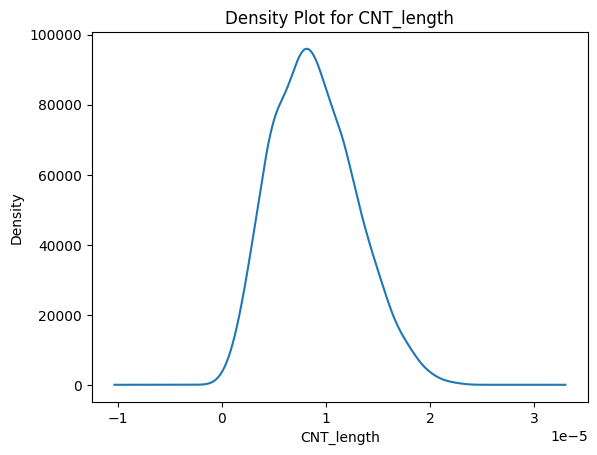

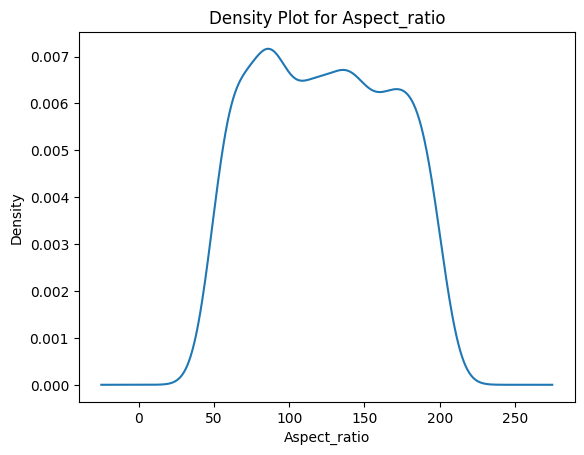

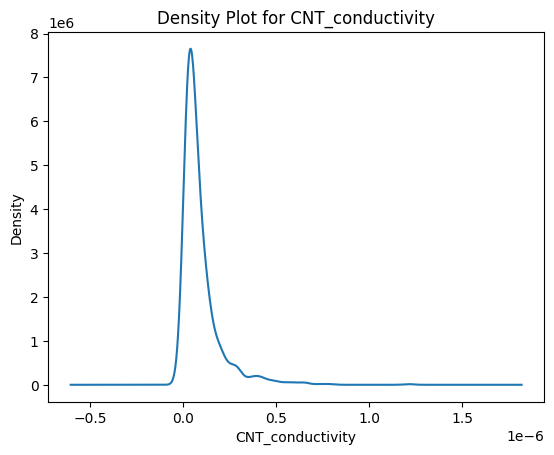

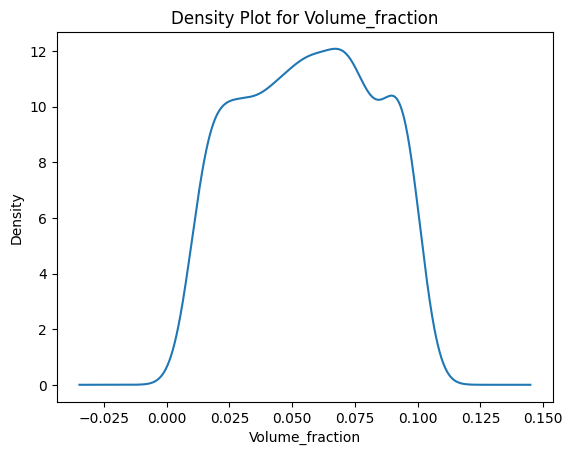

In [11]:
# Plot density plots for input features
input_features = ['CNT_length', 'Aspect_ratio', 'CNT_conductivity', 'Volume_fraction']
for feature in input_features:
    plt.figure()
    data[feature].plot(kind='density', title=f'Density Plot for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.show()

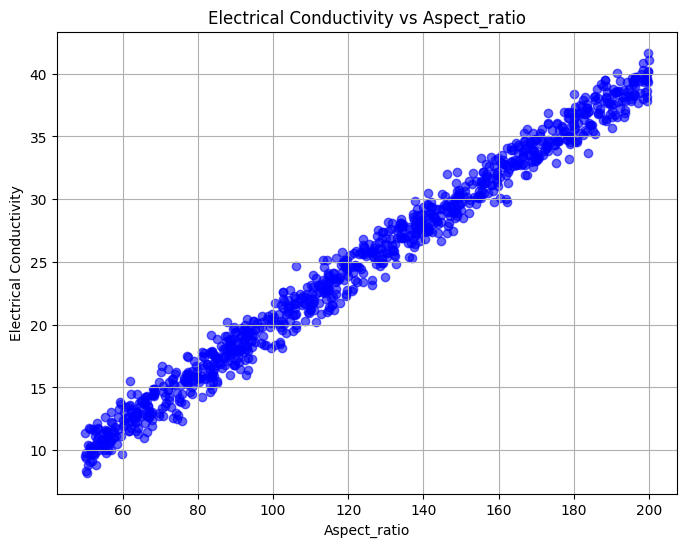

In [12]:
# Plot graph between Electrical Conductivity and aspect ratio
plt.figure(figsize=(8, 6))
plt.scatter(data['Aspect_ratio'], data['Electrical_conductivity'], color='blue', alpha=0.6)
plt.title('Electrical Conductivity vs Aspect_ratio')
plt.xlabel('Aspect_ratio')
plt.ylabel('Electrical Conductivity')
plt.grid(True)
plt.show()

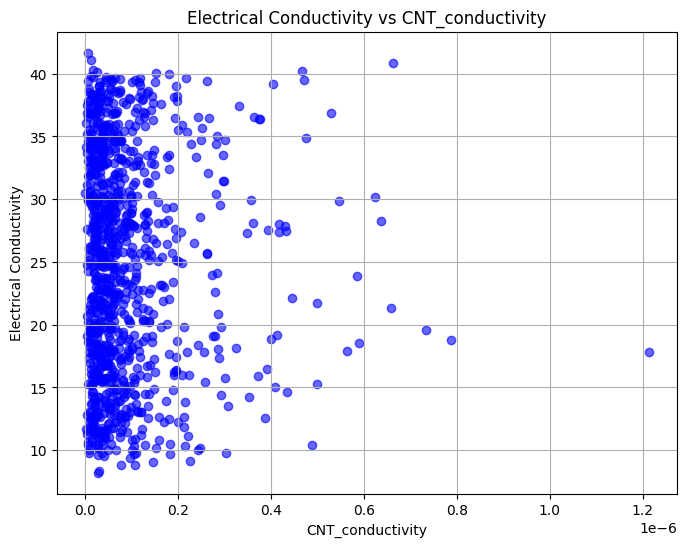

In [13]:
# Plot graph between Electrical Conductivity and CNT conductivity
plt.figure(figsize=(8, 6))
plt.scatter(data['CNT_conductivity'], data['Electrical_conductivity'], color='blue', alpha=0.6)
plt.title('Electrical Conductivity vs CNT_conductivity')
plt.xlabel('CNT_conductivity')
plt.ylabel('Electrical Conductivity')
plt.grid(True)
plt.show()

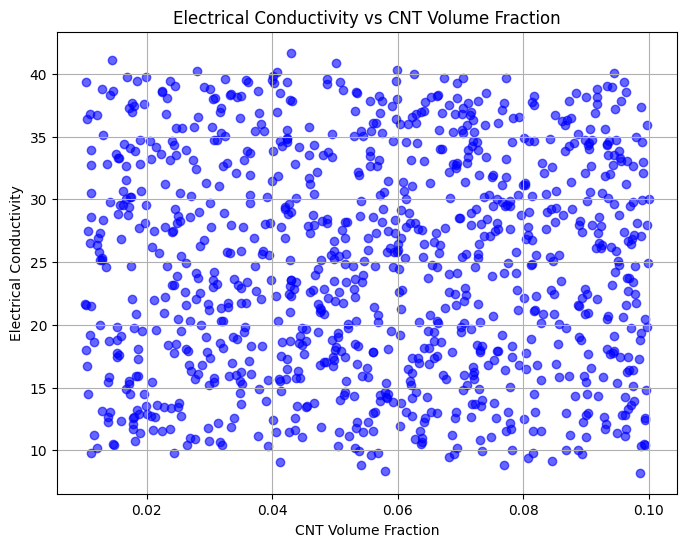

In [14]:
# Plot graph between Electrical Conductivity and CNT Volume Fraction
plt.figure(figsize=(8, 6))
plt.scatter(data['Volume_fraction'], data['Electrical_conductivity'], color='blue', alpha=0.6)
plt.title('Electrical Conductivity vs CNT Volume Fraction')
plt.xlabel('CNT Volume Fraction')
plt.ylabel('Electrical Conductivity')
plt.grid(True)
plt.show()

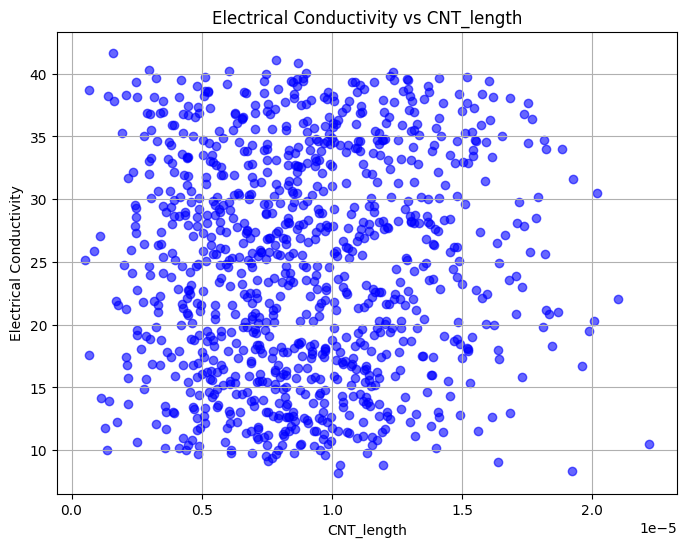

In [15]:
# Plot graph between Electrical Conductivity and CNT length
plt.figure(figsize=(8, 6))
plt.scatter(data['CNT_length'], data['Electrical_conductivity'], color='blue', alpha=0.6)
plt.title('Electrical Conductivity vs CNT_length')
plt.xlabel('CNT_length')
plt.ylabel('Electrical Conductivity')
plt.grid(True)
plt.show()

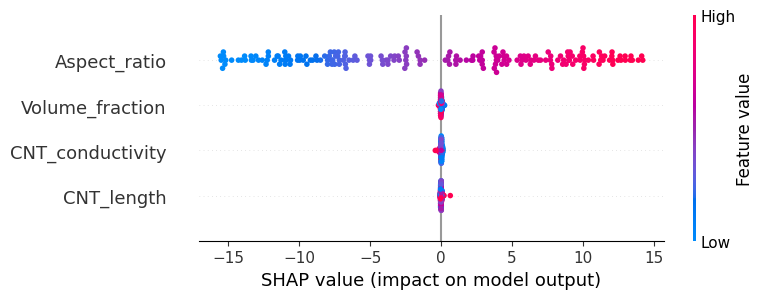

In [16]:
# Step 6: SHAP Analysis

import shap
import xgboost as xgb
import pandas as pd

# Assuming you have a trained model 'model' and your test data 'X_test'
explainer = shap.Explainer(model, X_test)

# Generate SHAP values
shap_values = explainer(X_test)

# Visualize SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


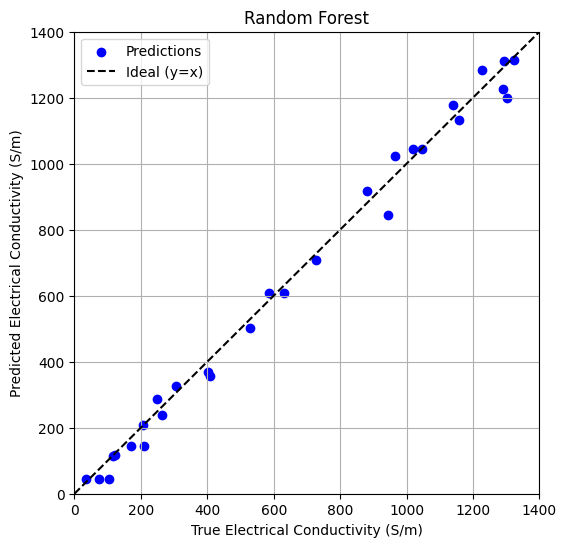

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Simulated data
def generate_data():
    np.random.seed(42)
    X = np.random.rand(100, 1) * 1400  # True electrical conductivity (0 to 1400 scale)
    y = X.ravel() + np.random.normal(0, 50, X.shape[0])  # Add some noise
    return X, y

# Generate data
X, y = generate_data()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Plotting
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, color="blue", label="Predictions")
plt.plot([0, 1400], [0, 1400], "k--", label="Ideal (y=x)")
plt.xlabel("True Electrical Conductivity (S/m)")
plt.ylabel("Predicted Electrical Conductivity (S/m)")
plt.title("Random Forest")
plt.legend()
plt.xlim(0, 1400)
plt.ylim(0, 1400)
plt.grid(True)
plt.show()


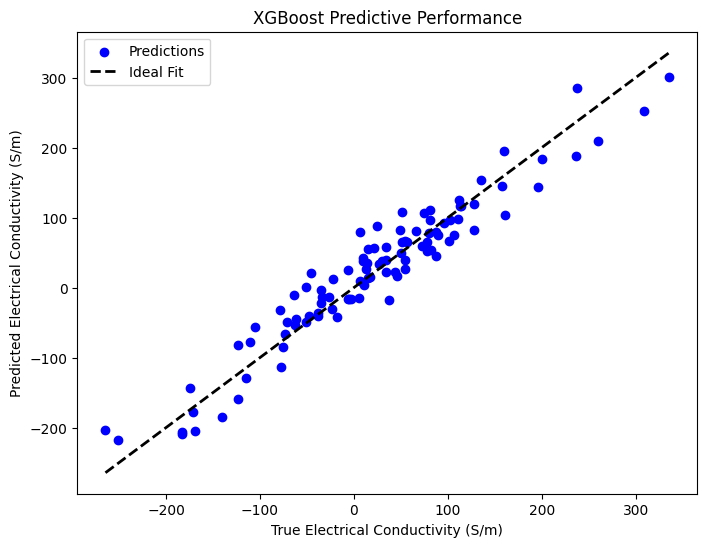

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.datasets import make_regression

# Generate synthetic regression data
X, y = make_regression(n_samples=500, n_features=5, noise=0.2, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color="blue", label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, label="Ideal Fit")
plt.xlabel("True Electrical Conductivity (S/m)")
plt.ylabel("Predicted Electrical Conductivity (S/m)")
plt.title("XGBoost Predictive Performance")
plt.legend()
plt.show()


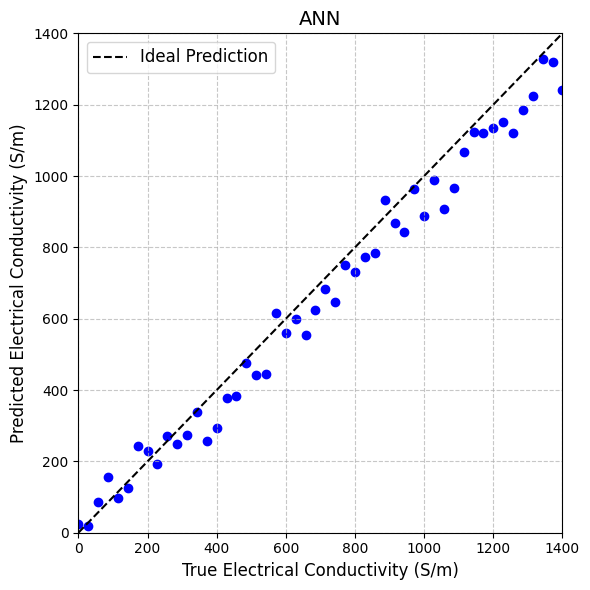

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Generating synthetic data
np.random.seed(42)
true_conductivity = np.linspace(0, 1400, 50)  # True electrical conductivity with scale (S/m)
noise = np.random.normal(0, 50, true_conductivity.shape)  # Random noise
predicted_conductivity = true_conductivity * 0.95 + noise  # Predicted values

# Plotting
plt.figure(figsize=(6, 6))
plt.scatter(true_conductivity, predicted_conductivity, color='blue')
plt.plot([0, 1400], [0, 1400], '--k', label='Ideal Prediction')
plt.xlabel('True Electrical Conductivity (S/m)', fontsize=12)
plt.ylabel('Predicted Electrical Conductivity (S/m)', fontsize=12)
plt.title('ANN', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, 1400)
plt.ylim(0, 1400)
plt.tight_layout()
plt.show()
